# Trabajo Practico de Laboratorio 2 - Filtros digitales
# Analisis de datos

In [26]:
import pandas as pd
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pytc2.sistemas_lineales import plot_plantilla

mpl.rcParams['figure.figsize'] = (10,4)


def get_gains(file):
    df_osc = pd.read_csv(file, usecols = ['freq','vin', 'vout'])
    freq = df_osc['freq']
    mag = [20*np.log10(x[1]/x[0]) for x in zip(df_osc['vin'], df_osc['vout'])] #Calculo la ganancia y convierto a dB

    return freq, mag

def get_gains_aa(file):
    df_osc = pd.read_csv(file, usecols = ['freq','gain'])
    freq = df_osc['freq']
    mag = df_osc['gain'] #Calculo la ganancia y convierto a dB

    return freq, mag

# Talkthrough

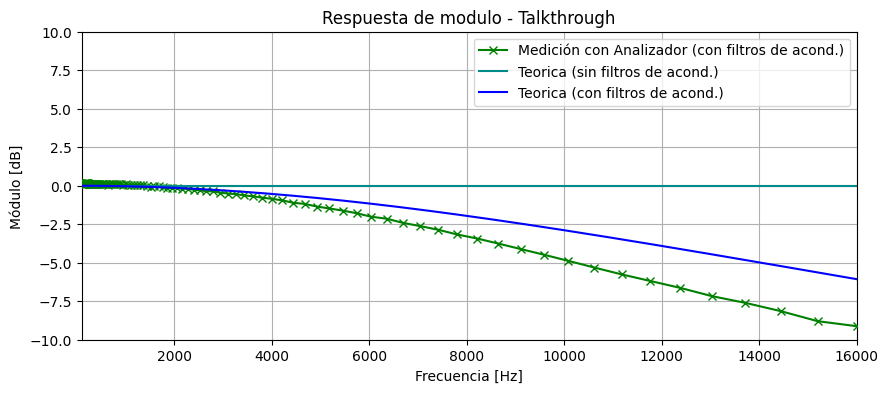

In [75]:
#Grafico de modulo de valores medidos experimentalmente con analizador de audio
tt_aa_w, tt_aa_gain = get_gains_aa('talkthrough_analizador.csv')
plt.plot(tt_aa_w, tt_aa_gain, marker='x', color='green', zorder=10, label='Medición con Analizador (con filtros de acond.)')

#Teorica teniendo en cuenta los filtros para bajos
R = 1e3
C = 10e-9
f_teorica = np.linspace(tt_aa_w.iloc[0], tt_aa_w.iloc[-1], 1000)
tt_teorica = [20*np.log10(1/(1 + (2*np.pi*f*R*C)**2)) for f in f_teorica]

plt.plot(f_teorica, np.zeros(len(f_teorica)), color='darkcyan', zorder=10, label='Teorica (sin filtros de acond.)')

plt.plot(f_teorica, tt_teorica, color='blue', zorder=10, label='Teorica (con filtros de acond.)')


plt.title('Respuesta de modulo - Talkthrough')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([tt_aa_w.iloc[0], tt_aa_w.iloc[-1], -10, 10 ]);

plt.legend()



# Filtro A - FIR Equiripple pasa bajos


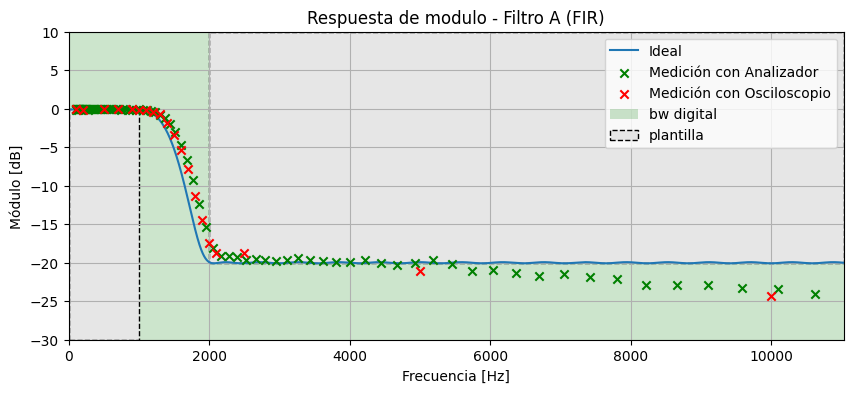

In [28]:
# Parametros del filtro

fs = 44100

num_taps= 151

att_pass = 0.1 # dB
att_stop = 20 # dB

wp1 = 1000 #Hz
ws1 = 2000 #Hz

# Calculos

gains_db = np.array([-att_pass, -att_pass, -att_stop, -att_stop])
gains = 10**(gains_db/20)

taps_fir_1 = signal.remez(num_taps, [0.0,  wp1,  ws1,  fs/2], gains[[1,2]], fs=fs)


plt.title('Respuesta de modulo - Filtro A (FIR)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([-2, fs/4, -30, 10 ]);

#Grafico de modulo teorico
fir_1_W, fir_1_H = signal.freqz(taps_fir_1, fs=fs, worN=10000)
plt.plot(fir_1_W, 20*np.log10(np.abs(fir_1_H)), label="Ideal")

#Grafico de modulo de valores medidos experimentalmente con analizador de audio
fir_1_aa_w, fir_1_aa_gain = get_gains_aa('filtro_a_analizador.csv')
plt.scatter(fir_1_aa_w, fir_1_aa_gain, marker='x', color='green', zorder=10, label='Medición con Analizador')

#Grafico de modulo de valores medidos experimentalmente con osciloscopio
fir_1_lab_w, fir_1_lab_gain = get_gains('filtro_a.csv')
plt.scatter(fir_1_lab_w, fir_1_lab_gain, marker='x', color='red', zorder=10, label='Medición con Osciloscopio')

#Grafico plantilla
plot_plantilla(filter_type = 'lowpass', fpass=wp1, fstop=ws1, ripple=att_pass, attenuation=att_stop, fs = fs)


plt.legend()



# Filtro B - FIR Least Squares elimina banda

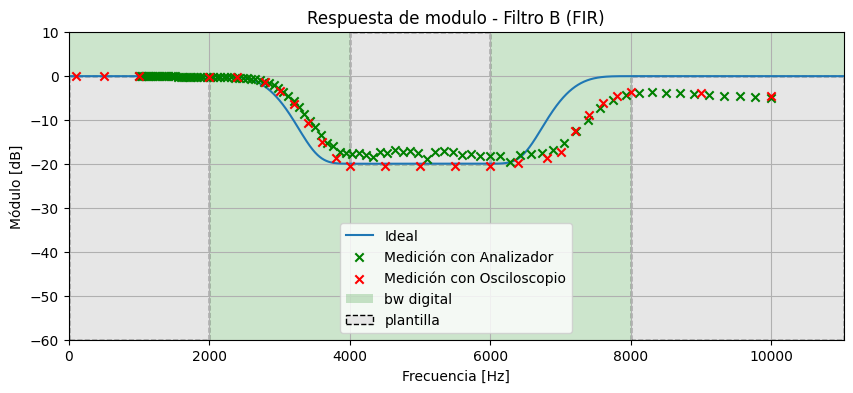

In [29]:
#Parametros del filtro

wp1 = 2e3
ws1 = 4e3
ws2 = 6e3
wp2 = 8e3

att_pass_db = 0.1
att_stop_db = 20

#Calculo filtro

gains_db = np.array([-att_pass_db, -att_pass_db, -att_stop_db, -att_stop_db, -att_pass_db, -att_pass_db])
gains = 10**(gains_db/20)

taps = signal.firls(num_taps, [0.0, wp1, ws1, ws2, wp2, fs/2], gains, fs=fs)


plt.title('Respuesta de modulo - Filtro B (FIR)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([-2, fs/4, -60, 10 ]);

#Grafico modulo teorico
fir_W, fir_H = signal.freqz(taps, fs=fs, worN=10000)
plt.plot(fir_W, 20*np.log10(np.abs(fir_H)), label="Ideal")

#Grafico de modulo de valores medidos experimentalmente con analizador de audio
fir_2_aa_w, fir_2_aa_gain = get_gains_aa('filtro_b_analizador.csv')
plt.scatter(fir_2_aa_w, fir_2_aa_gain, marker='x', color='green', zorder=10, label='Medición con Analizador')


#Grafico de modulo de valores medidos experimentalmente con osciloscopio
fir_2_lab_w, fir_2_lab_gain = get_gains('filtro_b.csv')
plt.scatter(fir_2_lab_w, fir_2_lab_gain, marker='x', color='red', zorder=10, label='Medición con Osciloscopio')

#Grafico plantilla
plot_plantilla(filter_type = 'bandstop', fpass=[wp1, wp2], fstop=[ws1, ws2], ripple=att_pass, attenuation=att_stop, fs = fs)


plt.legend()



# Filtro C - IIR Butterworth

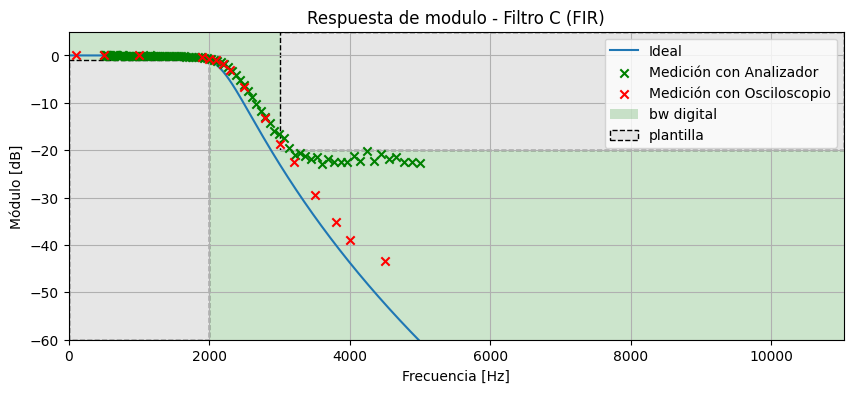

In [77]:
## Parametos del filtro

fs = 44.1e3

wc = 2e3
ws = 3e3
att_max_pass_db = 1
att_min_stop_db = 20

# Calculo de coeficientes
iir_sos = signal.iirdesign(wc, ws, att_max_pass_db, att_min_stop_db, ftype='butter', output='sos', analog=False, fs=fs)

a_coef = []
b_coef = []

for sos in iir_sos:
    b_coef.append(sos[:3])
    a_coef.append(sos[3:])

order = len(b_coef)

plt.title('Respuesta de modulo - Filtro C (FIR)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([-2, fs/4, -60, 5 ]);

#Grafico modulo teorico
iir_W, iir_H = signal.sosfreqz(iir_sos, fs=fs, worN=10000)
plt.plot(iir_W, 20*np.log10(np.abs(iir_H)), label="Ideal")

#Grafico de modulo de valores medidos experimentalmente con analizador de audio
iir_aa_w, iir_aa_gain = get_gains_aa('filtro_c_analizador.csv')
plt.scatter(iir_aa_w, iir_aa_gain, marker='x', color='green', zorder=10, label='Medición con Analizador')



#Grafico de modulo de valores medidos experimentalmente con osciloscopio
iir_lab_w, iir_lab_gain = get_gains('filtro_c.csv')
plt.scatter(iir_lab_w, iir_lab_gain, marker='x', color='red', zorder=10, label='Medición con Osciloscopio')



#Grafico plantilla
plot_plantilla(filter_type = 'lowpass', fpass=wc, fstop=ws, ripple=att_max_pass_db, attenuation=att_min_stop_db, fs = fs)

plt.legend()


